# Esercizio Rilevamento Frodi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.naive_bayes import MultinomialNB

df = pd.read_csv(r'C:\Users\simon\Desktop\Università\Esami terzo anno\Data Analytics\Esercizi\EsercizioEsame\Esercitazioni per esame\Rilevamento frodi\dataset csv\PS_20174392719_1491204439457_log.csv')
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [2]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df["isFraud"].unique()
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Così abbiamo appena verificato che ci sono circa 6KK di frodi e 8K di transazioni normali

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## 1°

Andiamo ad effettuare il preprocessing dei dati :
- Controlliamo se ci sono valori nulli/mancanti
- Controlliamo se c'è qualche errore di formattazione nella colonna tipo
- Controllare qualche valore negativo o outlier nelle colonne dei soldi

In [5]:
df = df.drop('isFlaggedFraud', axis=1)
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

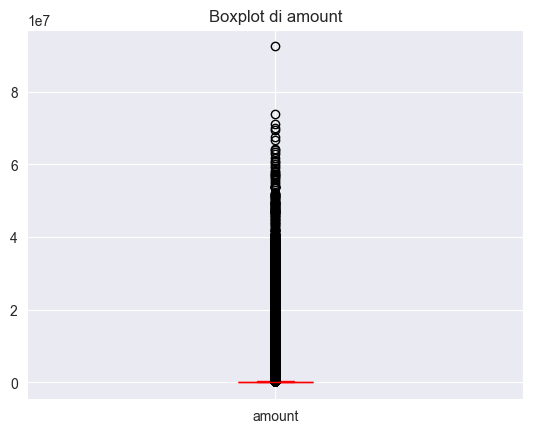

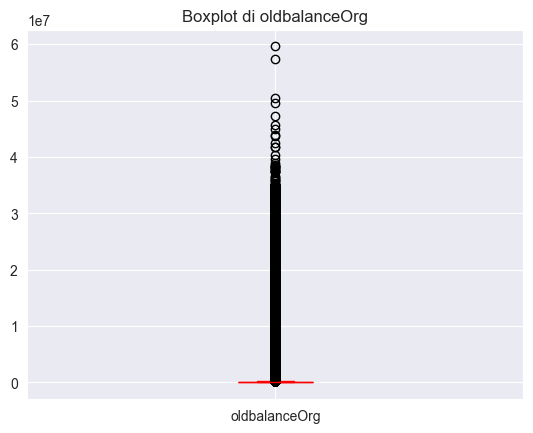

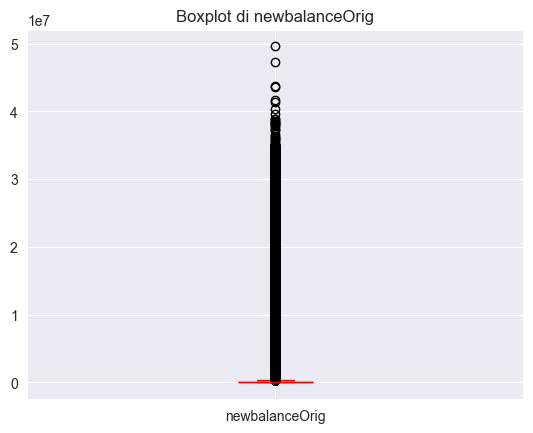

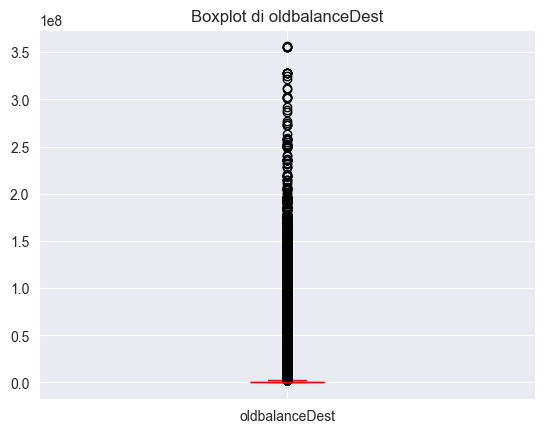

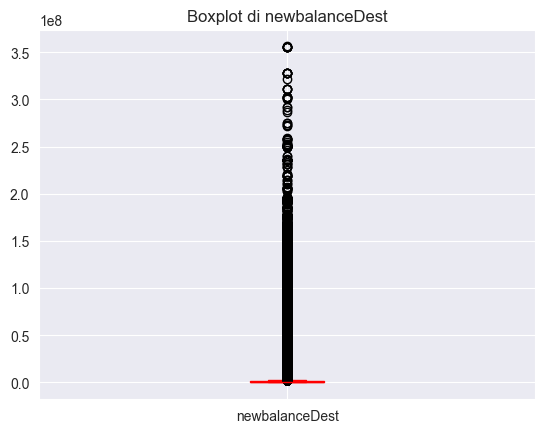

In [7]:
colonne = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for colonna in colonne:
    df.boxplot(column = colonna, patch_artist=True, color='red')     #Mettere colore diverso
    plt.title(f'Boxplot di {colonna}')
    plt.show()

In [8]:
df['oldbalanceOrg'].max()

59585040.37

In [9]:
df['oldbalanceOrg'][df['oldbalanceOrg']>40000000.64].value_counts().sum()

13

Ho fatto ciò per verificare se il valore di 59KK fosse un outlier

## 2°
Andiamo a codificare le variabili categoriche in variabili numeriche per poter
controllare la correlazione con la variabile target

In [10]:
codes1, uniques1 = pd.factorize(df['type'])
df['type'] = codes1
codes2, uniques2 = pd.factorize(df['nameOrig'])
df['nameOrig'] = codes2
codes3, uniques3 = pd.factorize(df['nameDest'])
df['nameDest'] = codes3
print('Prima:\n', uniques1, '\n', uniques2, '\n', uniques3)
print('\nDopo:\n', df['type'].unique(), '\n', df['nameOrig'].unique(), '\n', df['nameDest'].unique())

Prima:
 Index(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'], dtype='object') 
 Index(['C1231006815', 'C1666544295', 'C1305486145', 'C840083671',
       'C2048537720', 'C90045638', 'C154988899', 'C1912850431', 'C1265012928',
       'C712410124',
       ...
       'C778071008', 'C994950684', 'C1531301470', 'C1436118706', 'C2013999242',
       'C786484425', 'C1529008245', 'C1162922333', 'C1685995037',
       'C1280323807'],
      dtype='object', length=6353307) 
 Index(['M1979787155', 'M2044282225', 'C553264065', 'C38997010', 'M1230701703',
       'M573487274', 'M408069119', 'M633326333', 'M1176932104', 'C195600860',
       ...
       'C2078394828', 'C1930074465', 'C830041824', 'C114421319', 'C1744173808',
       'C1812552860', 'C1470998563', 'C1850423904', 'C1881841831',
       'C2080388513'],
      dtype='object', length=2722362)

Dopo:
 [0 1 2 3 4] 
 [      0       1       2 ... 6353304 6353305 6353306] 
 [      0       1       2 ... 2722359 2722360 2722361]


Matrice di correlazione:


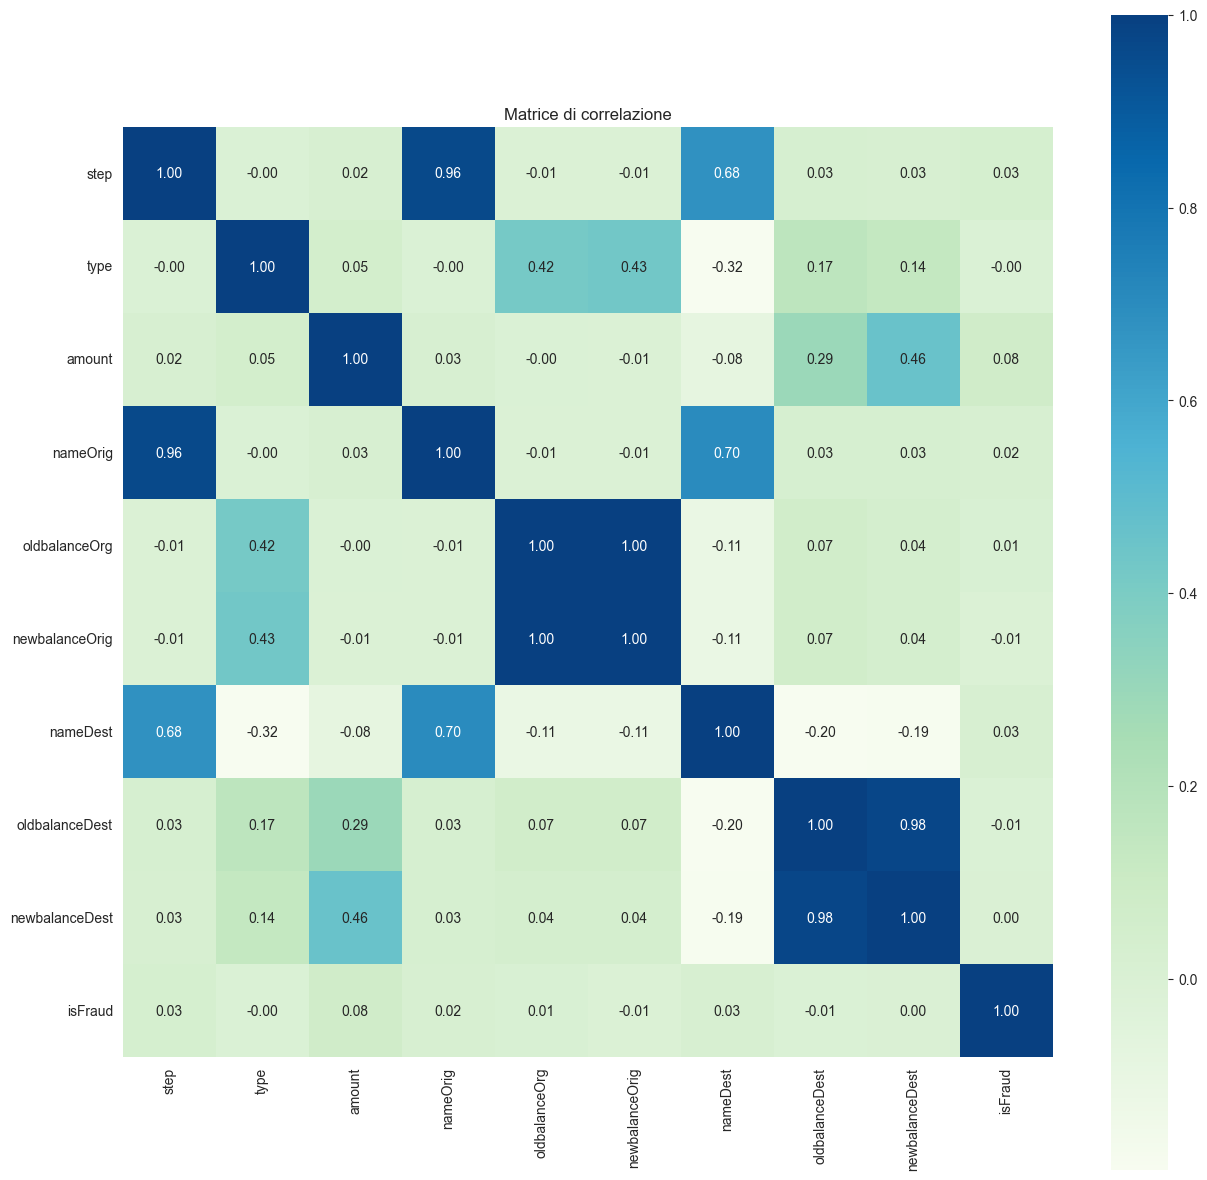

In [11]:
print('Matrice di correlazione:\n')
corr_matrix = df.corr()
plt.figure(figsize=(15,15))
plot = sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, fmt='.2f', cmap='GnBu', robust=True)
plt.title('Matrice di correlazione')
plt.show()

Come possiamo vedere dalla matrice di correlazione precedentemente stampata, non c'è un attributo correlato con la variabile target 

In [12]:
def remove_unrelated(df_model, threshold):
    corr = df_model.corr()
    corr_target = abs(corr['isFraud'])
    relevant_features = corr_target[corr_target > threshold]
    print("Le features maggiormente correlate con valore > di", threshold,"sono:\n")
    print(relevant_features)
    
    rel_feat = relevant_features.keys().tolist()
    new_df = df_model[rel_feat]
    
    return new_df

new_df = remove_unrelated(df, 0.025)

Le features maggiormente correlate con valore > di 0.025 sono:

step        0.031578
amount      0.076688
nameDest    0.025310
isFraud     1.000000
Name: isFraud, dtype: float64


## 3° e 4°

Andiamo ad addestrare e valutare i classificatori


Classificatore 1 - Decision Tree:


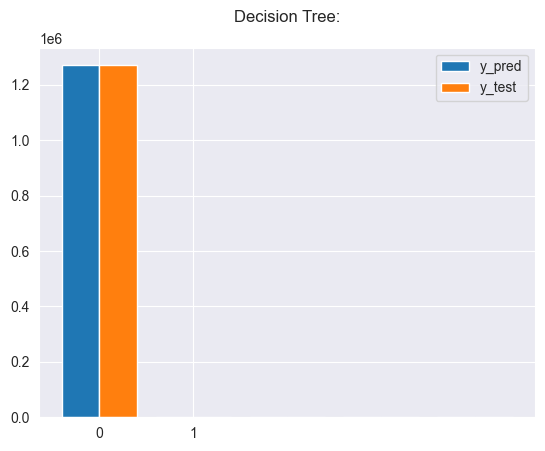

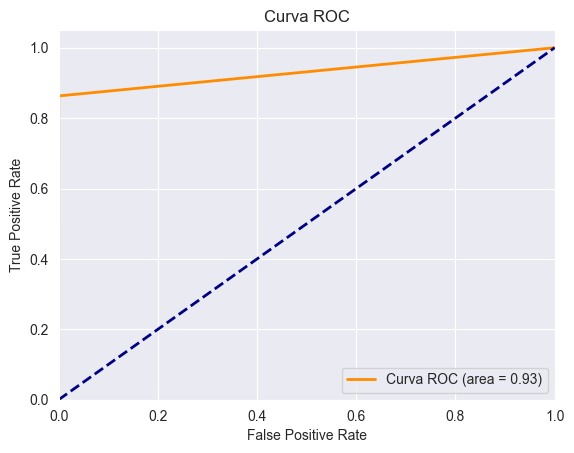

Accuracy: 0.9996715189654576
Precision: 0.9389747685542172
Recall: 0.9314343389826356
F_score: 0.9351718027136973
Matrice di confusione:
 [[1270701     195]
 [    223    1405]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270896
           1       0.88      0.86      0.87      1628

    accuracy                           1.00   1272524
   macro avg       0.94      0.93      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

Cross accuracy: 0.7528015188711568
Cross precision: 0.719303990468304
Cross recall: 0.7768293277500368
Cross f_score: 0.6151008185182137

Classificatore 2 - Naive Bayes:


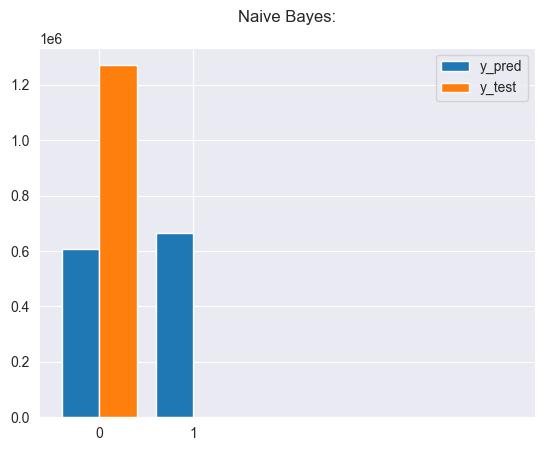

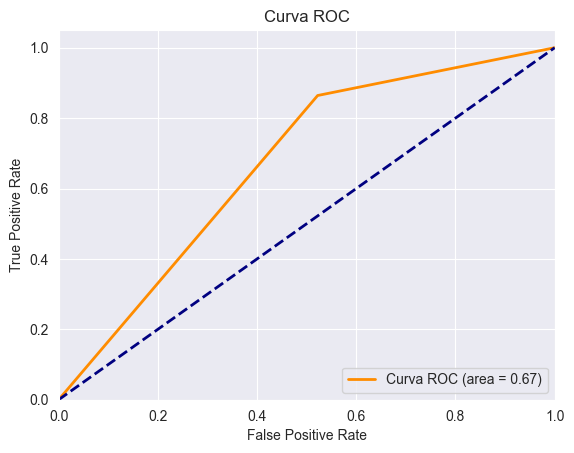

Accuracy: 0.4783241809191811
Precision: 0.5008759503237213
Recall: 0.671040214403322
F_score: 0.3254045810398879
Matrice di confusione:
 [[607272 663624]
 [   221   1407]]
              precision    recall  f1-score   support

           0       1.00      0.48      0.65   1270896
           1       0.00      0.86      0.00      1628

    accuracy                           0.48   1272524
   macro avg       0.50      0.67      0.33   1272524
weighted avg       1.00      0.48      0.65   1272524

Cross accuracy: 0.465921271425922
Cross precision: 0.5009153207706586
Cross recall: 0.6720563888252966
Cross f_score: 0.31723375912791696


In [14]:
x = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True) 
    
classifiers = [DecisionTreeClassifier(), MultinomialNB()]
names = ['Decision Tree:\n', 'Naive Bayes:\n']

for idx, (classifier, name) in enumerate(zip(classifiers, names)):
    
    print("\nClassificatore", idx+1, "-", name)
    
    classifier.fit(X_train, y_train)    
    y_pred = classifier.predict(X_test)
    
    
    plt.hist([y_pred, y_test], bins=[0, 1, 2, 3, 4, 5], label=['y_pred', 'y_test'], align='left') #
    plt.xticks([0,1])
    plt.title(name)
    plt.yscale('linear')
    plt.legend()
    plt.show()
    
    
    # Calcolo della curva ROC e dell'AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Disegna la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    #Eseguo cross-validation per 'migliorare' il classificatore
    scoring = {'precision':'precision_macro', 'recall':'recall_macro', 'f1_score':'f1_macro', 'accuracy':'accuracy'}
    score = cross_validate(classifier, x, y, scoring=scoring)
    cross_precision = score['test_precision'].mean()
    cross_accuracy = score['test_accuracy'].mean()
    cross_f_score = score['test_f1_score'].mean()
    cross_recall = score['test_recall'].mean()
    
    #Stampiamo metriche di valutazione, matrice di confusione e report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print('F_score:',f1)
    print('Matrice di confusione:\n',confusion)
    print(report)
    
    #Stampiamo le metriche della cross validation
    print('Cross accuracy:',cross_accuracy)
    print('Cross precision:',cross_precision)
    print('Cross recall:',cross_recall)
    print('Cross f_score:',cross_f_score)

Proviamo a riaddestrare e riusare i classificatori sul nuovo dataframe per vedere se le prestazioni sono effettivamente migliori


Classificatore 1 - Decision Tree:


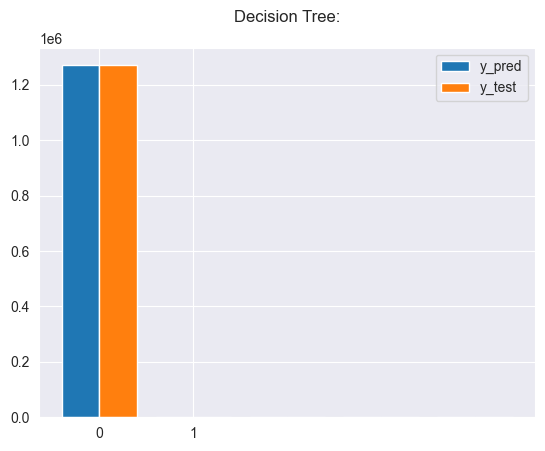

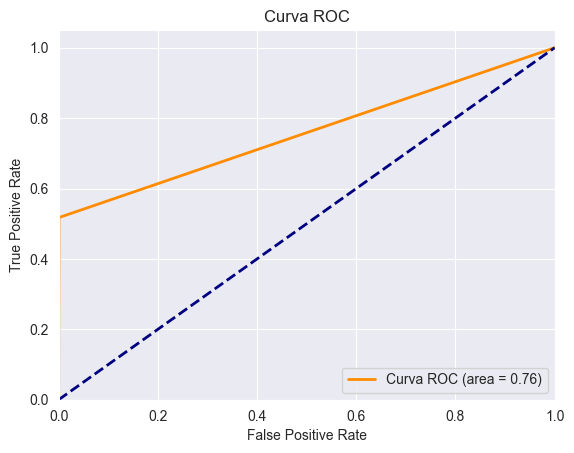

Accuracy: 0.9987253678516083
Precision: 0.7498408354080094
Recall: 0.75844995618337
F_score: 0.7540722060053433
Matrice di confusione:
 [[1270062     839]
 [    783     840]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270901
           1       0.50      0.52      0.51      1623

    accuracy                           1.00   1272524
   macro avg       0.75      0.76      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524

Cross accuracy: 0.3207801188818442
Cross precision: 0.504674899349731
Cross recall: 0.28522135222948597
Cross f_score: 0.1901562088462329

Classificatore 2 - Naive Bayes:


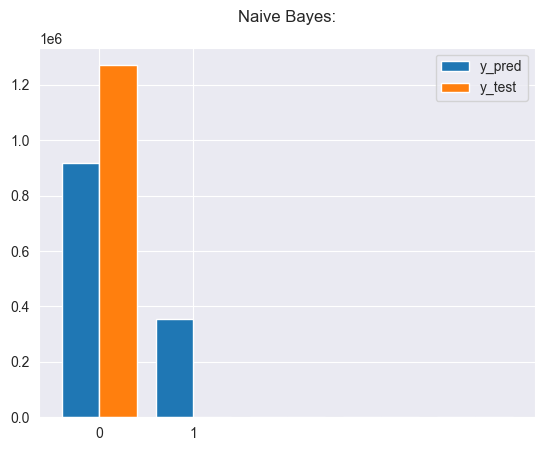

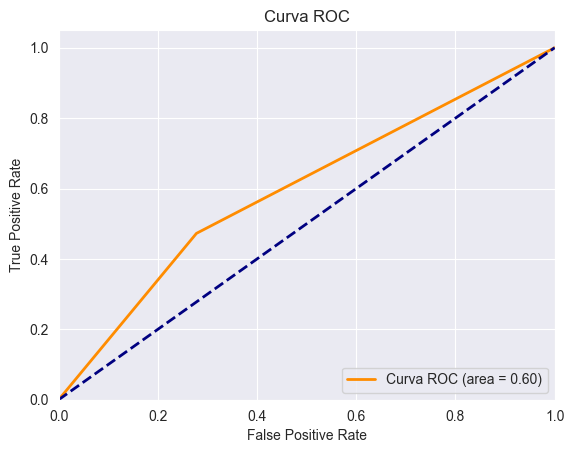

Accuracy: 0.7218755795568492
Precision: 0.5006179715212485
Recall: 0.597387789257693
F_score: 0.4213391680390967
Matrice di confusione:
 [[917837 353064]
 [   856    767]]
              precision    recall  f1-score   support

           0       1.00      0.72      0.84   1270901
           1       0.00      0.47      0.00      1623

    accuracy                           0.72   1272524
   macro avg       0.50      0.60      0.42   1272524
weighted avg       1.00      0.72      0.84   1272524

Cross accuracy: 0.7199757332671133
Cross precision: 0.500792522493134
Cross recall: 0.6000886069439006
Cross f_score: 0.41572345808867855


In [15]:
x = new_df.drop('isFraud', axis=1)
y = new_df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True) 
    
classifiers = [DecisionTreeClassifier(), MultinomialNB()]
names = ['Decision Tree:\n', 'Naive Bayes:\n']

for idx, (classifier, name) in enumerate(zip(classifiers, names)):
    
    print("\nClassificatore", idx+1, "-", name)
    
    classifier.fit(X_train, y_train)    
    y_pred = classifier.predict(X_test)
    
    
    plt.hist([y_pred, y_test], bins=[0, 1, 2, 3, 4, 5], label=['y_pred', 'y_test'], align='left') #
    plt.xticks([0,1])
    plt.title(name)
    plt.yscale('linear')
    plt.legend()
    plt.show()
    
    
    # Calcolo della curva ROC e dell'AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Disegna la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    #Eseguo cross-validation per 'migliorare' il classificatore
    scoring = {'precision':'precision_macro', 'recall':'recall_macro', 'f1_score':'f1_macro', 'accuracy':'accuracy'}
    score = cross_validate(classifier, x, y, scoring=scoring)
    cross_precision = score['test_precision'].mean()
    cross_accuracy = score['test_accuracy'].mean()
    cross_f_score = score['test_f1_score'].mean()
    cross_recall = score['test_recall'].mean()
    
    #Stampiamo metriche di valutazione, matrice di confusione e report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print('F_score:',f1)
    print('Matrice di confusione:\n',confusion)
    print(report)
    
    #Stampiamo le metriche della cross validation
    print('Cross accuracy:',cross_accuracy)
    print('Cross precision:',cross_precision)
    print('Cross recall:',cross_recall)
    print('Cross f_score:',cross_f_score)